# 6-3,使用GPU训练模型

深度学习的训练过程常常非常耗时，一个模型训练几个小时是家常便饭，训练几天也是常有的事情，有时候甚至要训练几十天。

训练过程的耗时主要来自于两个部分，一部分来自数据准备，另一部分来自参数迭代。

当数据准备过程还是模型训练时间的主要瓶颈时，我们可以使用更多进程来准备数据。

当参数迭代过程成为训练时间的主要瓶颈时，我们通常的方法是应用GPU来进行加速。

In [ ]:
!pip install -q torchkeras 
!pip install -q  -U torchmetrics

In [4]:
import torch 
import torchkeras 
import torchmetrics

print("torch.__version__ = ",torch.__version__)
print("torchkeras.__version__ = ",torchkeras.__version__)
print("torchmetrics.__version__ = ",torchmetrics.__version__)

torch.__version__ =  1.11.0
torchkeras.__version__ =  3.9.3
torchmetrics.__version__ =  0.11.4


注：本节代码只能在有GPU的机器环境上才能正确执行。

对于没有GPU的同学，推荐使用

在Colab笔记本中：修改->笔记本设置->硬件加速器 中选择 GPU

可点击如下链接，直接在kaggle中运行范例代码。

https://www.kaggle.com/lyhue1991/pytorch-gpu-examples

Pytorch中使用GPU加速模型非常简单，只要将模型和数据移动到GPU上。核心代码只有以下几行。

```python
# 定义模型
... 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) # 移动模型到cuda

# 训练模型
...

features = features.to(device) # 移动数据到cuda
labels = labels.to(device) # 或者  labels = labels.cuda() if torch.cuda.is_available() else labels
...
```

如果要使用多个GPU训练模型，也非常简单。只需要在将模型设置为数据并行风格模型。
则模型移动到GPU上之后，会在每一个GPU上拷贝一个副本，并把数据平分到各个GPU上进行训练。核心代码如下。

```python
# 定义模型
... 

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model) # 包装为并行风格模型

# 训练模型
...
features = features.to(device) # 移动数据到cuda
labels = labels.to(device) # 或者 labels = labels.cuda() if torch.cuda.is_available() else labels
...
```

## 〇，GPU相关操作汇总

In [5]:
import torch 
from torch import nn 

# 1，查看gpu信息
if_cuda = torch.cuda.is_available()
print("if_cuda=",if_cuda)

gpu_count = torch.cuda.device_count()
print("gpu_count=",gpu_count)


if_cuda= True
gpu_count= 1


In [6]:
# 2，将张量在gpu和cpu间移动
tensor = torch.rand((100,100))
tensor_gpu = tensor.to("cuda:0") # 或者 tensor_gpu = tensor.cuda()
print(tensor_gpu.device)
print(tensor_gpu.is_cuda)

tensor_cpu = tensor_gpu.to("cpu") # 或者 tensor_cpu = tensor_gpu.cpu() 
print(tensor_cpu.device)


cuda:0
True
cpu


In [7]:
# 3，将模型中的全部张量移动到gpu上
net = nn.Linear(2,1)
print(next(net.parameters()).is_cuda)
net.to("cuda:0") # 将模型中的全部参数张量依次到GPU上，注意，无需重新赋值为 net = net.to("cuda:0")
print(next(net.parameters()).is_cuda)
print(next(net.parameters()).device)


False
True
cuda:0


In [8]:
# 4，创建支持多个gpu数据并行的模型
linear = nn.Linear(2,1)
print(next(linear.parameters()).device)

model = nn.DataParallel(linear)
print(model.device_ids)
print(next(model.module.parameters()).device) 

#注意保存参数时要指定保存model.module的参数
torch.save(model.module.state_dict(), "model_parameter.pt") 

linear = nn.Linear(2,1)
linear.load_state_dict(torch.load("model_parameter.pt")) 


cpu
[0]
cuda:0


<All keys matched successfully>

## 一，矩阵乘法范例

下面分别使用CPU和GPU作一个矩阵乘法，并比较其计算效率。

In [9]:
import time
import torch 
from torch import nn

In [10]:
# 使用cpu
a = torch.rand((10000,200))
b = torch.rand((200,10000))
tic = time.time()
c = torch.matmul(a,b)
toc = time.time()

print(toc-tic)
print(a.device)
print(b.device)

0.6000046730041504
cpu
cpu


In [11]:
# 使用gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
a = torch.rand((10000,200),device = device) #可以指定在GPU上创建张量
b = torch.rand((200,10000)) #也可以在CPU上创建张量后移动到GPU上
b = b.to(device) #或者 b = b.cuda() if torch.cuda.is_available() else b 
tic = time.time()
c = torch.matmul(a,b)
toc = time.time()
print(toc-tic)
print(a.device)
print(b.device)


0.8443384170532227
cuda:0
cuda:0


## 二，线性回归范例

下面对比使用CPU和GPU训练一个线性回归模型的效率

### 1，使用CPU

In [12]:
# 准备数据
n = 1000000 #样本数量

X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0,-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0.t() + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动

In [13]:
# 定义模型
class LinearRegression(nn.Module): 
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn_like(w0))
        self.b = nn.Parameter(torch.zeros_like(b0))
    #正向传播
    def forward(self,x): 
        return x@self.w.t() + self.b
        
linear = LinearRegression() 


In [14]:
# 训练模型
optimizer = torch.optim.Adam(linear.parameters(),lr = 0.1)
loss_fn = nn.MSELoss()

def train(epoches):
    tic = time.time()
    for epoch in range(epoches):
        optimizer.zero_grad()
        Y_pred = linear(X) 
        loss = loss_fn(Y_pred,Y)
        loss.backward() 
        optimizer.step()
        if epoch%50==0:
            print({"epoch":epoch,"loss":loss.item()})
    toc = time.time()
    print("time used:",toc-tic)

train(500)

{'epoch': 0, 'loss': 258.9547119140625}
{'epoch': 50, 'loss': 33.212669372558594}
{'epoch': 100, 'loss': 9.038525581359863}
{'epoch': 150, 'loss': 4.485360145568848}
{'epoch': 200, 'loss': 4.017963409423828}
{'epoch': 250, 'loss': 3.994182825088501}
{'epoch': 300, 'loss': 3.993659734725952}
{'epoch': 350, 'loss': 3.9936563968658447}
{'epoch': 400, 'loss': 3.9936563968658447}
{'epoch': 450, 'loss': 3.9936563968658447}
time used: 5.222184896469116


### 2，使用GPU

In [15]:
# 准备数据
n = 1000000 #样本数量

X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0,-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0.t() + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动

# 数据移动到GPU上
print("torch.cuda.is_available() = ",torch.cuda.is_available())
X = X.cuda()
Y = Y.cuda()
print("X.device:",X.device)
print("Y.device:",Y.device)

torch.cuda.is_available() =  True
X.device: cuda:0
Y.device: cuda:0


In [16]:
# 定义模型
class LinearRegression(nn.Module): 
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn_like(w0))
        self.b = nn.Parameter(torch.zeros_like(b0))
    #正向传播
    def forward(self,x): 
        return x@self.w.t() + self.b
        
linear = LinearRegression() 

# 移动模型到GPU上
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
linear.to(device)

#查看模型是否已经移动到GPU上
print("if on cuda:",next(linear.parameters()).is_cuda)


if on cuda: True


In [17]:
# 训练模型
optimizer = torch.optim.Adam(linear.parameters(),lr = 0.1)
loss_fn = nn.MSELoss()

def train(epoches):
    tic = time.time()
    for epoch in range(epoches):
        optimizer.zero_grad()
        Y_pred = linear(X) 
        loss = loss_fn(Y_pred,Y)
        loss.backward() 
        optimizer.step()
        if epoch%50==0:
            print({"epoch":epoch,"loss":loss.item()})
    toc = time.time()
    print("time used:",toc-tic)
    
train(500)

{'epoch': 0, 'loss': 153.66574096679688}
{'epoch': 50, 'loss': 32.86173629760742}
{'epoch': 100, 'loss': 9.03520679473877}
{'epoch': 150, 'loss': 4.485783576965332}
{'epoch': 200, 'loss': 4.018568515777588}
{'epoch': 250, 'loss': 3.994813919067383}
{'epoch': 300, 'loss': 3.9942924976348877}
{'epoch': 350, 'loss': 3.994288921356201}
{'epoch': 400, 'loss': 3.9942891597747803}
{'epoch': 450, 'loss': 3.9942891597747803}
time used: 0.5444216728210449


## 三，图片分类范例

In [18]:
import torch 
from torch import nn 

import torchvision 
from torchvision import transforms

In [19]:
transform = transforms.Compose([transforms.ToTensor()])

ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)

dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)

print(len(ds_train))
print(len(ds_val))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

60000
10000


In [20]:
def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

net = create_net()
print(net)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)


### 1，使用CPU进行训练

In [22]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy
from torchmetrics import Accuracy
#注：多分类使用torchmetrics中的评估指标，二分类使用torchkeras.metrics中的评估指标

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")
    

net = create_net() 

loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = {"acc":Accuracy(task='multiclass',num_classes=10)}

epochs = 3 
ckpt_path='checkpoint.pt'

#early_stopping相关设置
monitor="val_acc"
patience=1
mode="max"

history = {}

for epoch in range(1, epochs+1):
    printlog("Epoch {0} / {1}".format(epoch, epochs))

    # 1，train -------------------------------------------------  
    net.train()
    
    total_loss,step = 0,0
    
    loop = tqdm(enumerate(dl_train), total =len(dl_train),file=sys.stdout)
    train_metrics_dict = deepcopy(metrics_dict) 
    
    for i, batch in loop: 
        
        features,labels = batch
        #forward
        preds = net(features)
        loss = loss_fn(preds,labels)
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        #metrics
        step_metrics = {"train_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in train_metrics_dict.items()}
        
        step_log = dict({"train_loss":loss.item()},**step_metrics)

        total_loss += loss.item()
        
        step+=1
        if i!=len(dl_train)-1:
            loop.set_postfix(**step_log)
        else:
            epoch_loss = total_loss/step
            epoch_metrics = {"train_"+name:metric_fn.compute().item() 
                             for name,metric_fn in train_metrics_dict.items()}
            epoch_log = dict({"train_loss":epoch_loss},**epoch_metrics)
            loop.set_postfix(**epoch_log)

            for name,metric_fn in train_metrics_dict.items():
                metric_fn.reset()
                
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]
        

    # 2，validate -------------------------------------------------
    net.eval()
    
    total_loss,step = 0,0
    loop = tqdm(enumerate(dl_val), total =len(dl_val),file=sys.stdout)
    
    val_metrics_dict = deepcopy(metrics_dict) 
    
    with torch.no_grad():
        for i, batch in loop: 

            features,labels = batch
            
            #forward
            preds = net(features)
            loss = loss_fn(preds,labels)

            #metrics
            step_metrics = {"val_"+name:metric_fn(preds, labels).item() 
                            for name,metric_fn in val_metrics_dict.items()}

            step_log = dict({"val_loss":loss.item()},**step_metrics)

            total_loss += loss.item()
            step+=1
            if i!=len(dl_val)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = (total_loss/step)
                epoch_metrics = {"val_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in val_metrics_dict.items()}
                epoch_log = dict({"val_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in val_metrics_dict.items():
                    metric_fn.reset()
                    
    epoch_log["epoch"] = epoch           
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 3，early-stopping -------------------------------------------------
    arr_scores = history[monitor]
    best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
    if best_score_idx==len(arr_scores)-1:
        torch.save(net.state_dict(),ckpt_path)
        print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
             arr_scores[best_score_idx]))
    if len(arr_scores)-best_score_idx>patience:
        print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
            monitor,patience))
        break 
    net.load_state_dict(torch.load(ckpt_path))
    
dfhistory = pd.DataFrame(history)


================================================================================2023-08-02 09:22:53
Epoch 1 / 3

100%|██████████| 79/79 [00:03<00:00, 22.00it/s, val_acc=0.965, val_loss=0.111] 
<<<<<< reach best val_acc : 0.9646000266075134 >>>>>>

================================================================================2023-08-02 09:23:33
Epoch 2 / 3

100%|██████████| 79/79 [00:03<00:00, 22.50it/s, val_acc=0.975, val_loss=0.0814]
<<<<<< reach best val_acc : 0.9749000072479248 >>>>>>

================================================================================2023-08-02 09:24:12
Epoch 3 / 3

100%|██████████| 79/79 [00:03<00:00, 23.03it/s, val_acc=0.964, val_loss=0.12]   
<<<<<< val_acc without improvement in 1 epoch, early stopping >>>>>>


CPU每个Epoch大概40s

### 2，使用GPU进行训练

In [23]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy
from torchmetrics import Accuracy
#注：多分类使用torchmetrics中的评估指标，二分类使用torchkeras.metrics中的评估指标

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")
    
net = create_net() 


loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = {"acc":Accuracy(task='multiclass',num_classes=10)}


# =========================移动模型到GPU上==============================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
loss_fn.to(device)
for name,fn in metrics_dict.items():
    fn.to(device)
# ====================================================================


epochs = 5 
ckpt_path='checkpoint.pt'

#early_stopping相关设置
monitor="val_acc"
patience=1
mode="max"

history = {}

for epoch in range(1, epochs+1):
    printlog("Epoch {0} / {1}".format(epoch, epochs))

    # 1，train -------------------------------------------------  
    net.train()
    
    total_loss,step = 0,0
    
    loop = tqdm(enumerate(dl_train), total =len(dl_train),file=sys.stdout)
    train_metrics_dict = deepcopy(metrics_dict) 
    
    for i, batch in loop: 
        
        features,labels = batch
        
        # =========================移动数据到GPU上==============================
        features = features.to(device)
        labels = labels.to(device)
        # ====================================================================
        
        #forward
        preds = net(features)
        loss = loss_fn(preds,labels)
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        #metrics
        step_metrics = {"train_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in train_metrics_dict.items()}
        
        step_log = dict({"train_loss":loss.item()},**step_metrics)

        total_loss += loss.item()
        
        step+=1
        if i!=len(dl_train)-1:
            loop.set_postfix(**step_log)
        else:
            epoch_loss = total_loss/step
            epoch_metrics = {"train_"+name:metric_fn.compute().item() 
                             for name,metric_fn in train_metrics_dict.items()}
            epoch_log = dict({"train_loss":epoch_loss},**epoch_metrics)
            loop.set_postfix(**epoch_log)

            for name,metric_fn in train_metrics_dict.items():
                metric_fn.reset()
                
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]
        

    # 2，validate -------------------------------------------------
    net.eval()
    
    total_loss,step = 0,0
    loop = tqdm(enumerate(dl_val), total =len(dl_val),file=sys.stdout)
    
    val_metrics_dict = deepcopy(metrics_dict) 
    
    with torch.no_grad():
        for i, batch in loop: 

            features,labels = batch
            
            # =========================移动数据到GPU上==============================
            features = features.to(device)
            labels = labels.to(device)
            # ====================================================================
            
            #forward
            preds = net(features)
            loss = loss_fn(preds,labels)

            #metrics
            step_metrics = {"val_"+name:metric_fn(preds, labels).item() 
                            for name,metric_fn in val_metrics_dict.items()}

            step_log = dict({"val_loss":loss.item()},**step_metrics)

            total_loss += loss.item()
            step+=1
            if i!=len(dl_val)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = (total_loss/step)
                epoch_metrics = {"val_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in val_metrics_dict.items()}
                epoch_log = dict({"val_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in val_metrics_dict.items():
                    metric_fn.reset()
                    
    epoch_log["epoch"] = epoch           
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 3，early-stopping -------------------------------------------------
    arr_scores = history[monitor]
    best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
    if best_score_idx==len(arr_scores)-1:
        torch.save(net.state_dict(),ckpt_path)
        print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
             arr_scores[best_score_idx]))
    if len(arr_scores)-best_score_idx>patience:
        print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
            monitor,patience))
        break 
    net.load_state_dict(torch.load(ckpt_path))
    
dfhistory = pd.DataFrame(history)


================================================================================2023-08-02 09:27:40
Epoch 1 / 5

100%|██████████| 79/79 [00:01<00:00, 56.00it/s, val_acc=0.972, val_loss=0.0912]
<<<<<< reach best val_acc : 0.972000002861023 >>>>>>

================================================================================2023-08-02 09:27:56
Epoch 2 / 5

100%|██████████| 79/79 [00:01<00:00, 40.13it/s, val_acc=0.98, val_loss=0.0672] 
<<<<<< reach best val_acc : 0.9800000190734863 >>>>>>

================================================================================2023-08-02 09:28:08
Epoch 3 / 5

100%|██████████| 79/79 [00:01<00:00, 55.83it/s, val_acc=0.964, val_loss=0.121] 
<<<<<< val_acc without improvement in 1 epoch, early stopping >>>>>>


使用GPU后每个Epoch只需要10秒钟左右，提升了4倍。


## 四，torchkeras.KerasModel中使用GPU

从上面的例子可以看到，在pytorch中使用GPU并不复杂，但对于经常炼丹的同学来说，模型和数据老是移来移去还是蛮麻烦的。

一不小心就会忘了移动某些数据或者某些module，导致报错。

torchkeras.KerasModel 在设计的时候考虑到了这一点，如果环境当中存在可用的GPU，会自动使用GPU，反之则使用CPU。

通过引入accelerate的一些基础功能，torchkeras.KerasModel以非常优雅的方式在GPU和CPU之间切换。

详细实现可以参考torchkeras.KerasModel的源码。

In [24]:
import  accelerate 
accelerator = accelerate.Accelerator()
print(accelerator.device)  

cuda


<<<<<< ⚡️ cuda is used >>>>>>


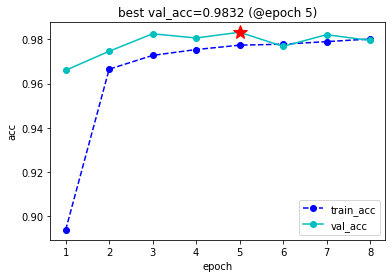

<<<<<< val_acc without improvement in 3 epoch,early stopping >>>>>> 



,epoch,train_loss,train_acc,lr,val_loss,val_acc
0,1,0.327403,0.893783,0.01,0.105610,0.9660
1,2,0.109891,0.966483,0.01,0.086295,0.9746
2,3,0.092442,0.972733,0.01,0.058266,0.9825
3,4,0.085473,0.975367,0.01,0.072749,0.9806
4,5,0.079213,0.977350,0.01,0.059756,0.9832
5,6,0.077976,0.977800,0.01,0.081202,0.9768
6,7,0.074797,0.978950,0.01,0.076534,0.9821
7,8,0.072074,0.980133,0.01,0.073126,0.9795


In [25]:
from torchkeras import KerasModel 
from torchmetrics import Accuracy

net = create_net() 
model = KerasModel(net,
                   loss_fn=nn.CrossEntropyLoss(),
                   metrics_dict = {"acc":Accuracy(task='multiclass',num_classes=10)},
                   optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)  )

model.fit(
    train_data = dl_train,
    val_data= dl_val,
    epochs=10,
    patience=3,
    monitor="val_acc", 
    mode="max")

### 

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)